# Zoidberg 2.0 - Bootstrap

We are going to use the **MNIST** dataset;

[**MNIST**](https://en.wikipedia.org/wiki/MNIST_database) stands for Mixed National Institute of Standards and Technology. It's a database of handwritten digits that is commonly used for training various image processing systems.

The training set is of shape `[60000,28,28]` which means :
1. 60,000 training images in total
2. Each image is a 28x28 grayscale image

Each number represents a shade of grey for a specific pixel; coordinates `[10,12,14]` represent this value for the pixel in line twelve, fourteenth column of the tenth image.

Now you are introduced with MNIST, let’s play with it:

- Create a class, import and load the datasets in four matrix with correct shapes ;
- Create a method to display basics statistics, like the distributions of each digit ;
- Create a method to display one desired image from a chosen dataset ;
- Each digit example has its own specificities: find a way to display the mean of each digit ;
- Use your class to create arrays and reshape the images datasets to size `[n,28x28]=[n,784]`.

## 1. Load the dataset in four matrix with correct shapes

I found the MNIST Dataset on Kaggle ([link](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)) but the file seems to be gzipped [IDX files](https://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html).

### IDX file format
The IDX file format is a simple format for vectors and multidimensional matrices of various numerical types.

The basic format according to http://yann.lecun.com/exdb/mnist/ is:
```
   magic number
   size in dimension 1
   size in dimension 2
   size in dimension 3
   ....
   size in dimension N
   data
```

The magic number is four bytes long. The first 2 bytes are always 0.

The third byte codes the type of the data:
```
   0x08: unsigned byte
   0x09: signed byte
   0x0B: short (2 bytes)
   0x0C: int (4 bytes)
   0x0D: float (4 bytes)
   0x0E: double (8 bytes)
```

The fourth byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (big endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest.

### Class to read an IDX file and return a NumPy Array

Train images matrix shape is: (60000, 28, 28)
The magic number is: b'\x00\x00\x08\x03'
Train labels matrix shape is: (60000,)
The magic number is: b'\x00\x00\x08\x01'
Images matrix shape is: (10000, 28, 28)
The magic number is: b'\x00\x00\x08\x03'
Labels matrix shape is: (10000,)
The magic number is: b'\x00\x00\x08\x01'
Digits distribution is:
 digits  train  test
      0   5923   980
      1   6742  1135
      2   5958  1032
      3   6131  1010
      4   5842   982
      5   5421   892
      6   5918   958
      7   6265  1028
      8   5851   974
      9   5949  1009


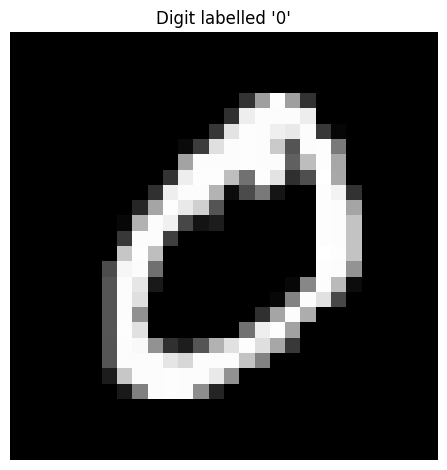

In [26]:
# https://docs.python.org/3/library/struct.html
import struct
from pathlib import Path
import numpy as npFunction
import matplotlib.pyplot as plt
from typing import Literal

DatasetType = Literal["train", "test"]

class IDXReader:

    PROJECT_ROOT: Path = Path('../../')
    RAW_DATA: Path = PROJECT_ROOT / 'data/01_raw'

    def __init__(self):
        train_images_path = IDXReader.RAW_DATA / 'train-images.idx3-ubyte'
        self.train_images = idx.read(train_images_path)
        print("Train images matrix shape is:", train_images.shape)
        self.display_magic_number(train_images_path)

        train_labels_path = IDXReader.RAW_DATA / 'train-labels.idx1-ubyte'
        self.train_labels = idx.read(train_labels_path)
        print("Train labels matrix shape is:", train_labels.shape)
        self.display_magic_number(train_labels_path)

        images_path = IDXReader.RAW_DATA / 't10k-images.idx3-ubyte'
        self.test_images = idx.read(images_path)
        print("Images matrix shape is:", self.test_images.shape)
        self.display_magic_number(images_path)

        labels_path = IDXReader.RAW_DATA / 't10k-labels.idx1-ubyte'
        self.test_labels = idx.read(labels_path)
        print("Labels matrix shape is:", self.test_labels.shape)
        self.display_magic_number(labels_path)
        
    def display_magic_number(self, idx_file_path: str | Path) -> None:
        with open(idx_file_path, mode='rb') as f:
            print("The magic number is:", f.read(4))
    
    def read(self, filename: str | Path):
        """
        Reads a IDX file and returns a NumPy array.

        IDX Format:
            - The magic number is four bytes long. The first 2 bytes are always 0.
            - The third byte codes the type of the data
            - The fourth byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....
            - The sizes in each dimension are 4-byte integers (big endian, like in most non-Intel processors).
        """
        with open(filename, 'rb') as f:
            # Read the magic number (first 4 bytes) 
            magic: int = struct.unpack('>I', f.read(4))[0]

            # IDX data type codes dictionnary
            dt_dict = {
                0x08: np.uint8,
                0x09: np.int8,
                0x0B: np.int16,
                0x0C: np.int32,
                0x0D: np.float32,
                0x0E: np.float64
            }

            # https://stackoverflow.com/questions/14713102/what-does-and-0xff-do
            # IDX uses big-endian integers, we make a 8 bit shift to throw away
            # the 4th byte (the dimensions) then we isolate the 3rd byte with
            # the ``& 0xFF`` mask.
            data_type = dt_dict[(magic >> 8) & 0xff]
        
            # The fourth byte indicates the number of dimensions 
            ndim: int = magic & 0xff
        
            # Read N unsigned integers in the big-endian format
            dims = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        
            # Read all the data 
            data = np.frombuffer(f.read(), dtype=data_type)
            data = data.reshape(dims)
        
            return data
            
    def display_digits_distribution(self) -> None:
        train_digits_distribution = pd.Series(train_labels).value_counts()
        test_digits_distribution = pd.Series(labels).value_counts()

        df = pd.DataFrame({
            'train': train_digits_distribution,
            'test': test_digits_distribution,
        })

        df = df.reset_index()
        df = df.sort_values('index')
        df = df.rename(columns={'index':  'digits'}, )
        
        print("Digits distribution is:")
        print(df.to_string(index=False))
            
    def display_image(self, image_number: int, dataset_type: DatasetType) -> None:
        images = self.train_images if dataset_type == 'train' else self.test_images
        labels = self.train_labels if dataset_type == 'train' else self.test_labels
    
        plt.figure()
        ax = plt.imshow(images[image_number], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f"Digit labelled '{labels[image_number]}'")
        plt.tight_layout()
        plt.show()


idx = IDXReader()
idx.display_digits_distribution()
idx.display_image(1, 'train')